# 论文4：循环神经网络正则化
## Wojciech Zaremba, Ilya Sutskever, Oriol Vinyals (2014)

### RNN的Dropout

关键洞察：仅在**非循环连接**上应用dropout，而非循环连接。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 标准Dropout

In [2]:
def dropout(x, dropout_rate=0.5, training=True):
    """
    标准dropout
    训练期间：以概率dropout_rate随机将元素置零
    测试期间：按 (1 - dropout_rate) 缩放
    """
    if not training or dropout_rate == 0:
        return x
    
    # 反向dropout（训练期间缩放）
    mask = (np.random.rand(*x.shape) > dropout_rate).astype(float)
    return x * mask / (1 - dropout_rate)

# 测试dropout
x = np.ones((5, 1))
print("原始:", x.T)
print("使用dropout (p=0.5):", dropout(x, 0.5).T)
print("使用dropout (p=0.5):", dropout(x, 0.5).T)
print("测试模式:", dropout(x, 0.5, training=False).T)

原始: [[1. 1. 1. 1. 1.]]
使用dropout (p=0.5): [[0. 2. 2. 2. 0.]]
使用dropout (p=0.5): [[0. 0. 2. 2. 2.]]
测试模式: [[1. 1. 1. 1. 1.]]


## 带有适当Dropout的RNN

**关键**：在**输入**和**输出**上使用Dropout，而非循环连接！

In [3]:
class RNNWithDropout:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 权重
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.W_hy = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs, dropout_rate=0.0, training=True):
        """
        带dropout的前向传播
        
        Dropout应用于：
        1. 输入连接 (x -> h)
        2. 输出连接 (h -> y)
        
        不应用于：
        - 循环连接 (h -> h)
        """
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        hidden_states = []
        
        for x in inputs:
            # 对INPUT应用dropout
            x_dropped = dropout(x, dropout_rate, training)
            
            # RNN更新（循环连接上无dropout）
            h = np.tanh(
                np.dot(self.W_xh, x_dropped) +  # 在这里应用dropout
                np.dot(self.W_hh, h) +           # 这里不应用dropout
                self.bh
            )
            
            # 在输出前对HIDDEN状态应用dropout
            h_dropped = dropout(h, dropout_rate, training)
            
            # 输出
            y = np.dot(self.W_hy, h_dropped) + self.by  # 在这里应用dropout
            
            outputs.append(y)
            hidden_states.append(h)
        
        return outputs, hidden_states

# 测试
rnn = RNNWithDropout(input_size=10, hidden_size=20, output_size=10)
test_inputs = [np.random.randn(10, 1) for _ in range(5)]

outputs_train, _ = rnn.forward(test_inputs, dropout_rate=0.5, training=True)
outputs_test, _ = rnn.forward(test_inputs, dropout_rate=0.5, training=False)

print(f"训练输出[0]均值: {outputs_train[0].mean():.4f}")
print(f"测试输出[0]均值: {outputs_test[0].mean():.4f}")

训练输出[0]均值: 0.0007
测试输出[0]均值: 0.0005


## 变分Dropout

**关键创新**：在所有时间步使用**相同**的dropout掩码！

In [4]:
class RNNWithVariationalDropout:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 权重（与之前相同）
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.W_hy = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    def forward(self, inputs, dropout_rate=0.0, training=True):
        """
        变分dropout：所有时间步使用相同掩码
        """
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        hidden_states = []
        
        # 为整个序列生成一次掩码
        if training and dropout_rate > 0:
            input_mask = (np.random.rand(self.input_size, 1) > dropout_rate).astype(float) / (1 - dropout_rate)
            hidden_mask = (np.random.rand(self.hidden_size, 1) > dropout_rate).astype(float) / (1 - dropout_rate)
        else:
            input_mask = np.ones((self.input_size, 1))
            hidden_mask = np.ones((self.hidden_size, 1))
        
        for x in inputs:
            # 对每个输入应用相同掩码
            x_dropped = x * input_mask
            
            # RNN更新
            h = np.tanh(
                np.dot(self.W_xh, x_dropped) +
                np.dot(self.W_hh, h) +
                self.bh
            )
            
            # 对每个隐藏状态应用相同掩码
            h_dropped = h * hidden_mask
            
            # 输出
            y = np.dot(self.W_hy, h_dropped) + self.by
            
            outputs.append(y)
            hidden_states.append(h)
        
        return outputs, hidden_states

# 测试变分dropout
var_rnn = RNNWithVariationalDropout(input_size=10, hidden_size=20, output_size=10)
outputs_var, _ = var_rnn.forward(test_inputs, dropout_rate=0.5, training=True)

print("变分dropout在所有时间步使用一致的掩码")

变分dropout在所有时间步使用一致的掩码


## 比较Dropout策略

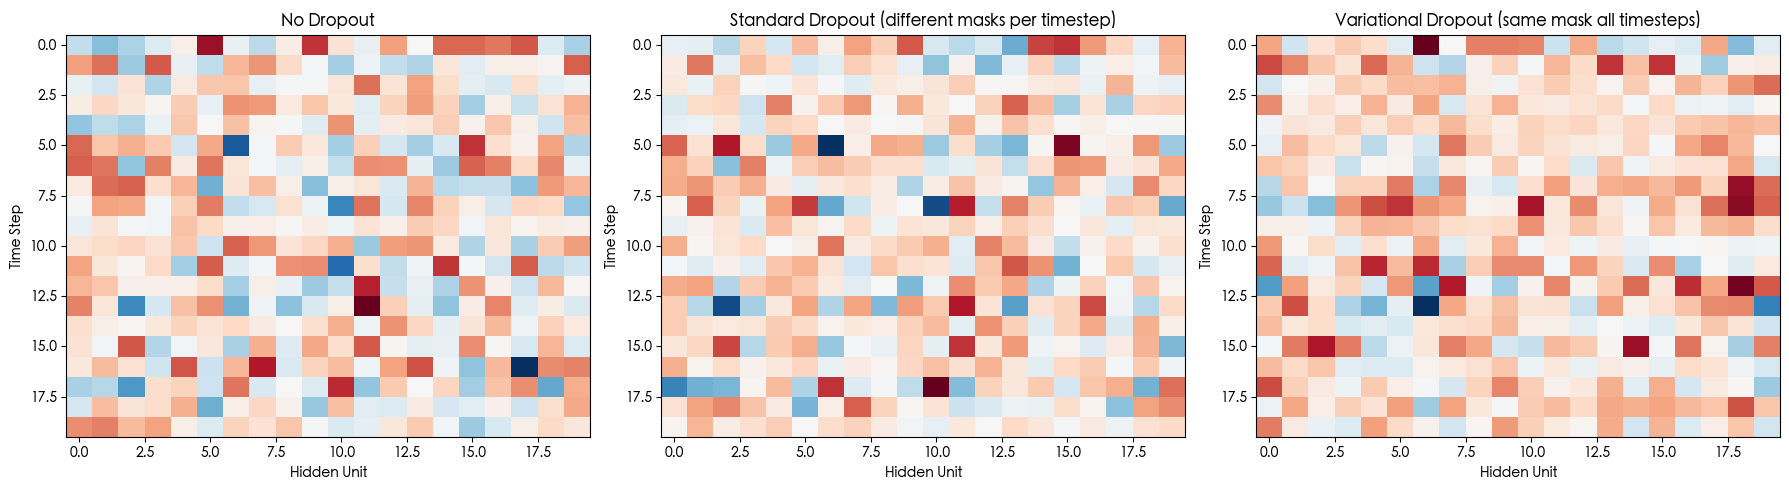

Variational dropout shows consistent patterns (same units dropped throughout)


In [5]:
# Generate synthetic sequence data
seq_length = 20
test_sequence = [np.random.randn(10, 1) for _ in range(seq_length)]

# Run with different strategies
_, h_no_dropout = rnn.forward(test_sequence, dropout_rate=0.0, training=False)
_, h_standard = rnn.forward(test_sequence, dropout_rate=0.5, training=True)
_, h_variational = var_rnn.forward(test_sequence, dropout_rate=0.5, training=True)

# Convert to arrays: shape should be (seq_length, hidden_size)
# Each h is (hidden_size, 1), we want rows as time steps, columns as hidden units
h_no_dropout = np.array([h.flatten() for h in h_no_dropout])
h_standard = np.array([h.flatten() for h in h_standard])
h_variational = np.array([h.flatten() for h in h_variational])

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(h_no_dropout, cmap='RdBu', aspect='auto')
axes[0].set_title('No Dropout')
axes[0].set_xlabel('Hidden Unit')
axes[0].set_ylabel('Time Step')

axes[1].imshow(h_standard, cmap='RdBu', aspect='auto')
axes[1].set_title('Standard Dropout (different masks per timestep)')
axes[1].set_xlabel('Hidden Unit')
axes[1].set_ylabel('Time Step')

axes[2].imshow(h_variational, cmap='RdBu', aspect='auto')
axes[2].set_title('Variational Dropout (same mask all timesteps)')
axes[2].set_xlabel('Hidden Unit')
axes[2].set_ylabel('Time Step')

plt.tight_layout()
plt.show()

print("Variational dropout shows consistent patterns (same units dropped throughout)")

## Dropout的位置很重要！

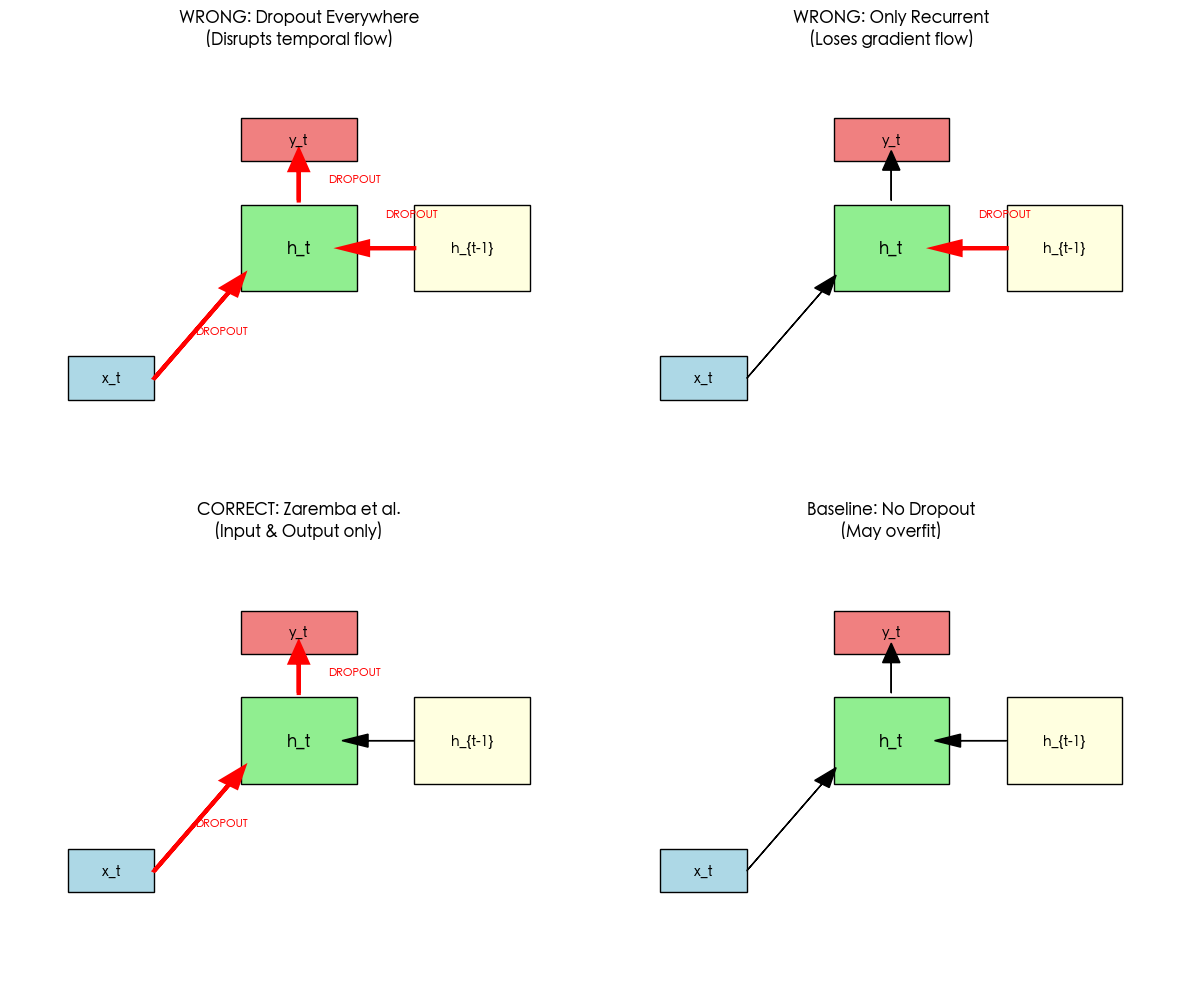

In [ ]:
# Visualize where dropout is applied
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Create a simple RNN diagram
def draw_rnn_cell(ax, title, show_input_dropout, show_hidden_dropout, show_recurrent_dropout):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Draw boxes
    # Input
    ax.add_patch(plt.Rectangle((1, 2), 1.5, 1, fill=True, color='lightblue', ec='black'))
    ax.text(1.75, 2.5, 'x_t', ha='center', va='center', fontsize=10)
    
    # Hidden (current)
    ax.add_patch(plt.Rectangle((4, 4.5), 2, 2, fill=True, color='lightgreen', ec='black'))
    ax.text(5, 5.5, 'h_t', ha='center', va='center', fontsize=12)
    
    # Hidden (previous)
    ax.add_patch(plt.Rectangle((7, 4.5), 2, 2, fill=True, color='lightyellow', ec='black'))
    ax.text(8, 5.5, 'h_{t-1}', ha='center', va='center', fontsize=10)
    
    # Output
    ax.add_patch(plt.Rectangle((4, 7.5), 2, 1, fill=True, color='lightcoral', ec='black'))
    ax.text(5, 8, 'y_t', ha='center', va='center', fontsize=10)
    
    # Arrows
    # Input to hidden
    color_input = 'red' if show_input_dropout else 'black'
    width_input = 3 if show_input_dropout else 1
    ax.arrow(2.5, 2.5, 1.3, 2, head_width=0.3, color=color_input, lw=width_input)
    if show_input_dropout:
        ax.text(3.2, 3.5, 'DROPOUT', fontsize=8, color='red', fontweight='bold')
    
    # Recurrent
    color_rec = 'red' if show_recurrent_dropout else 'black'
    width_rec = 3 if show_recurrent_dropout else 1
    ax.arrow(7, 5.5, -0.8, 0, head_width=0.3, color=color_rec, lw=width_rec)
    if show_recurrent_dropout:
        ax.text(6.5, 6.2, 'DROPOUT', fontsize=8, color='red', fontweight='bold')
    
    # Hidden to output
    color_hidden = 'red' if show_hidden_dropout else 'black'
    width_hidden = 3 if show_hidden_dropout else 1
    ax.arrow(5, 6.6, 0, 0.7, head_width=0.3, color=color_hidden, lw=width_hidden)
    if show_hidden_dropout:
        ax.text(5.5, 7, 'DROPOUT', fontsize=8, color='red', fontweight='bold')

# Wrong: dropout everywhere
draw_rnn_cell(axes[0, 0], 'WRONG: Dropout Everywhere\n(Disrupts temporal flow)', 
             show_input_dropout=True, show_hidden_dropout=True, show_recurrent_dropout=True)

# Wrong: only recurrent
draw_rnn_cell(axes[0, 1], 'WRONG: Only Recurrent\n(Loses gradient flow)', 
             show_input_dropout=False, show_hidden_dropout=False, show_recurrent_dropout=True)

# Correct: Zaremba et al.
draw_rnn_cell(axes[1, 0], 'CORRECT: Zaremba et al.\n(Input & Output only)', 
             show_input_dropout=True, show_hidden_dropout=True, show_recurrent_dropout=False)

# No dropout
draw_rnn_cell(axes[1, 1], 'Baseline: No Dropout\n(May overfit)', 
             show_input_dropout=False, show_hidden_dropout=False, show_recurrent_dropout=False)

plt.tight_layout()
plt.show()

## 关键要点

### 问题：
- RNN上的朴素dropout效果不佳
- 丢弃循环连接会破坏时间信息流
- 标准dropout在每个时间步改变掩码（噪声大）

### Zaremba等人的解决方案：

**对以下项应用dropout：**
- ✅ 输入到隐藏连接 (W_xh)
- ✅ 隐藏到输出连接 (W_hy)

**不要对以下项应用：**
- ❌ 循环连接 (W_hh)

### 变分Dropout：
- 在所有时间步使用**相同的dropout掩码**
- 比改变掩码更稳定
- 更好的理论证明（贝叶斯）

### 结果：
- 语言建模显著改进
- Penn Treebank: 测试困惑度从78.4改进到68.7
- 也适用于LSTM和GRU

### 实现技巧：
1. 使用比前馈网络更高的dropout率（0.5-0.7）
2. 在双向RNN的**两个**方向上应用dropout
3. 可以堆叠多个LSTM层，在它们之间使用dropout
4. 变分dropout：每个序列生成一次掩码

### 为什么有效：
- 保持时间依赖（循环上无dropout）
- 正则化非时间变换
- 强制对缺失输入特征的鲁棒性
- 一致掩码（变分）减少方差